In [ ]:
!pip install yfinance

     |████████████████████████████████| 5.5MB 5.9MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=05cc80e1dc130019f839570d7e7fe9641378062cf036149ac037e5b9090e953e
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [ ]:
import yfinance as yf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1 DLP naif
## 1.1 - 1.4 Construction de GAN


In [ ]:
### 3 - 1 ###

BATCH = 64
# DATA_SIZE = 400
NOISE_DIM = 10
SIGNAL_DIM = 100


def log_return(ticker):
    tickers = np.log(yf.download(ticker)['Adj Close'].dropna())
    logret = tickers.diff().dropna()
    return logret.values.reshape((-1, 1))


def train_set(ticker):
    logret = log_return(ticker)
    X= list()
    for i in range(len(logret)):
        # find the end of this pattern
        end_ix = i + SIGNAL_DIM
        # check if we are beyond the sequence
        if end_ix > len(logret)-1:
            break
            
        # gather input and output parts of the pattern
        seq_x = logret[i:end_ix, :].flatten().tolist()
        X.append(seq_x)
    X = np.asarray(X, dtype=np.float32)
    print(X.shape)
    # logret = 2 * (logret - np.min(logret)) / np.ptp(logret) - 1
    X *= 10
    return tf.data.Dataset.from_tensor_slices(X).shuffle(X.shape[0]).batch(BATCH)


def generator(in_, out_, bias=True):
    if in_ > out_ :
        print("generator size error")
        return None
    model = Sequential([
                        Dense(in_ + int((out_ - in_) / 4), input_shape=(in_,), activation='relu', use_bias = bias),
                        BatchNormalization(),
                        Dense(in_ + int((out_ - in_) / 2), activation='relu', use_bias = bias),
                        BatchNormalization(),
                        Dense(in_ + int((out_ - in_) / 4 * 3), activation='relu', use_bias = bias),
                        BatchNormalization(),
                        Dense(out_, activation='tanh', use_bias = bias)
    ])
    print('=== Generator params ===')
    print(model.summary())
    return model


def discriminator(in_, bias=True):
    model = Sequential([
                        Dense(int(in_ / 4), input_shape=(in_, ), activation=LeakyReLU(alpha=0.1), use_bias = bias),
                        Dropout(0.3),
                        Dense(int(in_ / 4), activation=LeakyReLU(alpha=0.1), use_bias = bias),
                        Dropout(0.3),
                        Dense(int(in_ / 4), activation=LeakyReLU(alpha=0.1), use_bias = bias),
                        Dropout(0.3),
                        Dense(1, activation='sigmoid', use_bias = bias)
    ])
    print('=== Discriminator params ===')
    print(model.summary())
    return model


def disc_loss(rout, fout):
    rloss = CROSS_ENTROPY(tf.ones_like(rout), rout)
    floss = CROSS_ENTROPY(tf.ones_like(fout), fout)
    return rloss + floss


def gen_loss(fout):
    return CROSS_ENTROPY(tf.ones_like(fout), fout)


GEN = generator(NOISE_DIM, SIGNAL_DIM)
DIS = discriminator(SIGNAL_DIM)
CROSS_ENTROPY = BinaryCrossentropy(from_logits=True)
GEN_OPTIM = Adam(1e-4)
DIS_OPTIM = Adam(1e-4)


@tf.function
def train_step(signal):
    noise = tf.random.normal([BATCH, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_signal = GEN(noise, training=True)

        rout = DIS(signal, training=True)
        fout = DIS(gen_signal, training=True)

        genloss = gen_loss(fout)
        discloss = disc_loss(rout, fout)
    
    gen_grad = gen_tape.gradient(genloss, GEN.trainable_variables)
    disc_grad = disc_tape.gradient(discloss, DIS.trainable_variables)

    GEN_OPTIM.apply_gradients(zip(gen_grad, GEN.trainable_variables))
    DIS_OPTIM.apply_gradients(zip(disc_grad, DIS.trainable_variables))


def train_gan(dataset, epochs):     
    for epoch in range(epochs):
        if epoch % 10 == 0:
            print('training process : ', epoch)
        for batch in dataset:
            train_step(batch)



=== Generator params ===
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 32)                352       
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_9 (Dense)              (None, 55)                1815      
_________________________________________________________________
batch_normalization_4 (Batch (None, 55)                220       
_________________________________________________________________
dense_10 (Dense)             (None, 77)                4312      
_________________________________________________________________
batch_normalization_5 (Batch (None, 77)                308       
_________________________________________________________________
dense_11 (Dense)             

In [ ]:
dataset = train_set("^GSPC")

[*********************100%***********************]  1 of 1 completed
(23319, 100)


In [ ]:
train_gan(dataset, 10)

training process :  0


## 1.5 Génération de séries de rendement

tf.Tensor(
[[1.]
 [1.]
 [1.]], shape=(3, 1), dtype=float32)


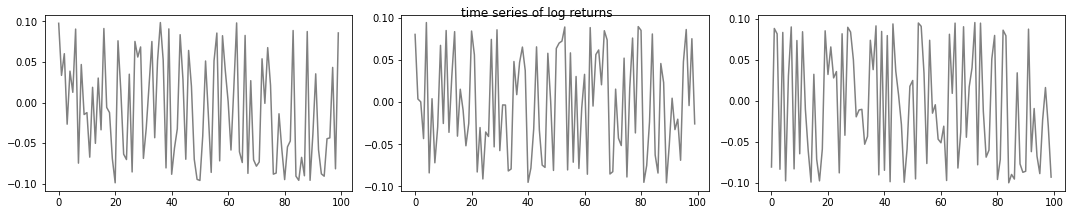

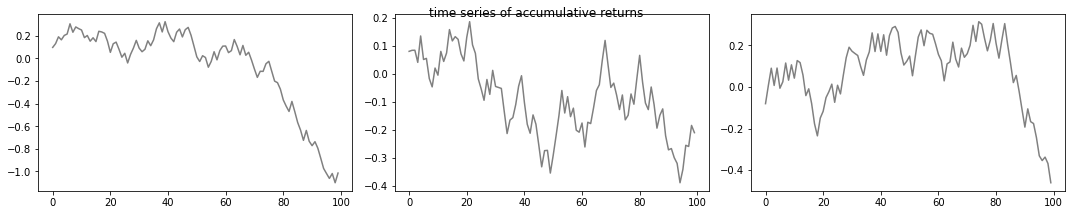

In [ ]:
NUM_SAMPLE = 3
SEED = tf.random.normal([NUM_SAMPLE, NOISE_DIM])

predictions = GEN(SEED, training=False)
critics = DIS(predictions, training=False)
print(critics)

fig = plt.figure(figsize=(15, 3))

for i in range(predictions.shape[0]):
    plt.subplot(1, NUM_SAMPLE, i+1)
    plt.plot(predictions[i, :] / 10, c='gray')
fig.suptitle('time series of log returns')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15, 3))

for i in range(predictions.shape[0]):
    plt.subplot(1, NUM_SAMPLE, i+1)
    plt.plot(np.cumsum(predictions[i, :].numpy() / 10), c='gray')
fig.suptitle('time series of accumulative returns')
plt.tight_layout()
plt.show()

[Conclusion]: On peut constater les séries de rendement similaires. Mais les rendements cumulés sont différents.

## 1.6 Test des faits stylisés


In [ ]:
from statsmodels.distributions.empirical_distribution import ECDF

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


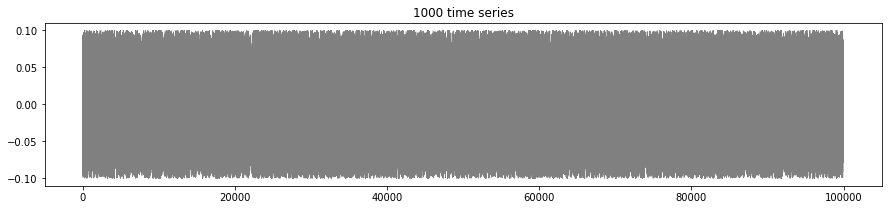

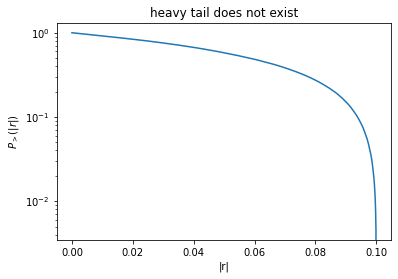

In [ ]:
NUM_SAMPLE = 1000
SEED = tf.random.normal([NUM_SAMPLE, NOISE_DIM])

predictions = (GEN(SEED, training=False).numpy() / 10).flatten()

plt.figure(figsize=(15, 3))
plt.title('1000 time series')
plt.plot(predictions, c='gray', linewidth=0.5)
plt.show()

x = np.linspace(np.min(abs(predictions)), np.max(abs(predictions)), 1000)
ecdf = ECDF(np.abs(predictions))
plt.yscale("log")
plt.ylabel('$P_{>}(|r|)$')
plt.xlabel('|r|')
plt.title('heavy tail does not exist')
plt.plot(x, 1- ecdf(x))


# 2 DLP moins naif


## 2.1 Model

In [ ]:
GEN_nb = generator(NOISE_DIM, SIGNAL_DIM, bias=False)
DIS_nb = discriminator(SIGNAL_DIM, bias=False)
CROSS_ENTROPY = BinaryCrossentropy(from_logits=True)
GEN_OPTIM = Adam(1e-4)
DIS_OPTIM = Adam(1e-4)


@tf.function
def train_step_nb(signal):
    noise = tf.random.normal([BATCH, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_signal = GEN_nb(noise, training=True)

        rout = DIS_nb(signal, training=True)
        fout = DIS_nb(gen_signal, training=True)

        genloss = gen_loss(fout)
        discloss = disc_loss(rout, fout)
    
    gen_grad = gen_tape.gradient(genloss, GEN_nb.trainable_variables)
    disc_grad = disc_tape.gradient(discloss, DIS_nb.trainable_variables)

    GEN_OPTIM.apply_gradients(zip(gen_grad, GEN_nb.trainable_variables))
    DIS_OPTIM.apply_gradients(zip(disc_grad, DIS_nb.trainable_variables))


def train_gan_nb(dataset, epochs):     
    for epoch in range(epochs):
        if epoch % 10 == 0:
            print('training process : ', epoch)
        for batch in dataset:
            train_step_nb(batch)

=== Generator params ===
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 32)                320       
_________________________________________________________________
batch_normalization_6 (Batch (None, 32)                128       
_________________________________________________________________
dense_17 (Dense)             (None, 55)                1760      
_________________________________________________________________
batch_normalization_7 (Batch (None, 55)                220       
_________________________________________________________________
dense_18 (Dense)             (None, 77)                4235      
_________________________________________________________________
batch_normalization_8 (Batch (None, 77)                308       
_________________________________________________________________
dense_19 (Dense)             

In [ ]:
dataset = train_set("^GSPC")
train_gan_nb(dataset, 10)

[*********************100%***********************]  1 of 1 completed
(23319, 100)
training process :  0


## 2.2 Génération de séries

tf.Tensor(
[[1.]
 [1.]
 [1.]], shape=(3, 1), dtype=float32)


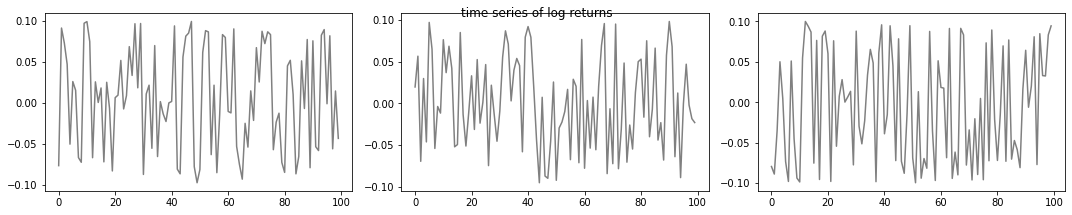

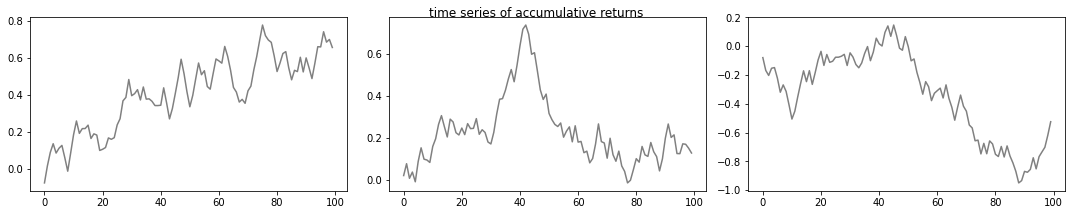

In [ ]:
NUM_SAMPLE = 3
SEED = tf.random.normal([NUM_SAMPLE, NOISE_DIM])

predictions = GEN_nb(SEED, training=False)
critics = DIS_nb(predictions, training=False)
print(critics)

fig = plt.figure(figsize=(15, 3))

for i in range(predictions.shape[0]):
    plt.subplot(1, NUM_SAMPLE, i+1)
    plt.plot(predictions[i, :] / 10, c='gray')
fig.suptitle('time series of log returns')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(15, 3))

for i in range(predictions.shape[0]):
    plt.subplot(1, NUM_SAMPLE, i+1)
    plt.plot(np.cumsum(predictions[i, :].numpy() / 10), c='gray')
fig.suptitle('time series of accumulative returns')
plt.tight_layout()
plt.show()

On peut constater les différences parmi les séries générées. Par exemple l'amplitude de la vibration, et la fréquence d'oscilliaiton varie en fonction de temps.

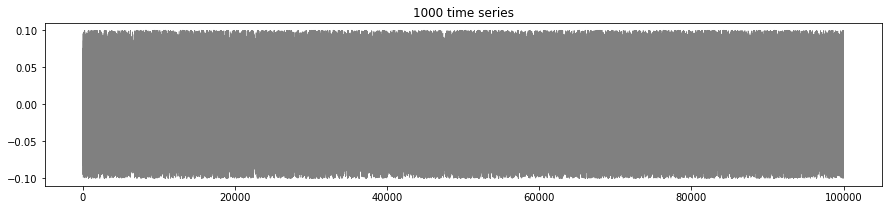

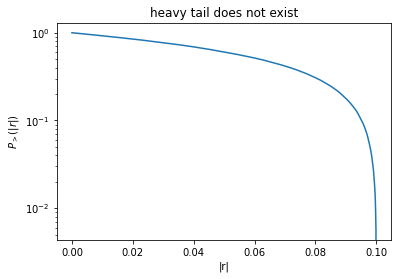

In [ ]:
NUM_SAMPLE = 1000
SEED = tf.random.normal([NUM_SAMPLE, NOISE_DIM])

predictions = (GEN_nb(SEED, training=False).numpy() / 10).flatten()

plt.figure(figsize=(15, 3))
plt.title('1000 time series')
plt.plot(predictions, c='gray', linewidth=0.5)
plt.show()

x = np.linspace(np.min(abs(predictions)), np.max(abs(predictions)), 1000)
ecdf = ECDF(np.abs(predictions))
plt.yscale("log")
plt.ylabel('$P_{>}(|r|)$')
plt.xlabel('|r|')
plt.title('heavy tail does not exist')
plt.plot(x, 1- ecdf(x))


Il n'y a pas de queue grasse non plus.

## 2.3 Heavy tail in GAN
In this article, an efficient NN is introduced to reproduce highly-simulated financial time series:<br>
Shuntaro Takahashi, Yu Chen and Kumiko Tanaka-Ishii. Modeling financial time-series with generative adversarial networks. Physica A. 527, 121261, 2019
link : https://www.sciencedirect.com/science/article/abs/pii/S0378437119307277
<br>
github implementation : 
https://github.com/stakahashy/fingan